# Graph SLAM Problem

$\min J(x_i) = x_0^T\Omega_0 x_0 + \sum_t e_t R_t^{-1} e_t  + \sum_t \sum_i \tilde{z}^i_t  Q_t^{-1} \tilde{z}^i_t + \$

$ e_t \equiv x_t - g(u_t, x_{t-1})$ prediction error at time t

$\tilde{z}^i_t \equiv z^i_t - h(x_t, m^i_t)$ measurement error

$\dot{p_x} = v_x$

$\dot{p_y} = v_y$

$x_t = \begin{bmatrix} p_x \\ p_y \end{bmatrix}$
$u_t = \begin{bmatrix} v_x \\ v_y \end{bmatrix}$

$x_t = x_{t-1} + \Delta_t u_t $

$g(u_t, x_t{-1}) = x_{t-1}  + \Delta_t u_t$

--> 161 z_factor=np.append(z,np.expand_dims(i*np.ones[len(z),1],axis=1))Landmarks are points. And our measurement is relative position.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import casadi as ca
import slam2d
import SF2D
import time

0.6480319499969482
[0.01014524 0.06837201 0.07750258 0.08447906 0.26995941 0.29638514
 0.31336222 0.32125421 0.3231672  0.34678919 0.36401223 0.36292177
 0.36202135 0.361277   0.36066119 0.36015146 0.35972935 0.35937965
 0.35908985 0.37260397 0.38976353 0.40444803 0.40490962 0.40457926
 0.40425761 0.40394436 0.40363922 0.40334191 0.40305219 0.40276984
 1.60179733 1.67829897 1.93758479 1.92929032 1.92675842 1.9608586
 1.96936224 1.96870734 1.96811449 1.96756482 1.96705073 1.9665682
 1.96611454 1.96568763 1.96528568 1.96490705 1.96455027 1.96421398
 1.96389693 1.96359795 1.96331596 1.96304994 1.96279897 1.96256216
 1.96233869 1.96212778 1.96192873 1.96174084 1.96156348 1.96139605]


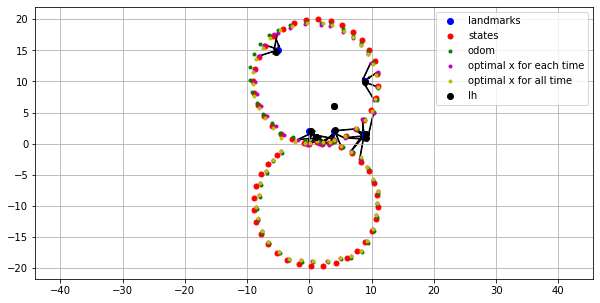

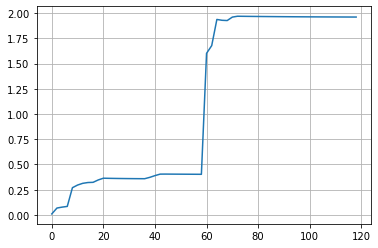

In [3]:
noise={
    'odom_std': 0.1,
    'bearing_std': 0,
    'range_std': 0.05,
    'odom_bx_bias': 0,
    'odom_by_bias': 0
}

plt.figure(figsize=(10, 5))

t0 = time.time()

sim = slam2d.simulate(noise=noise, plot=True, symf=True, tf=120);
#sf: true-symforce, false-casadi

tf =  time.time() - t0
print(tf)

print(sim['hist']['J'])

plt.figure()
plt.plot(sim['hist']['t'], sim['hist']['J'][:])
plt.grid()

In [1]:
x=sim['hist']['xh']
lm=sim['hist']['lh'][-1]
odom=sim['hist']['odom'][:,0:2]
z = sim['hist']['z']
z = np.append(z,np.expand_dims(sim['hist']['assoc'],1),axis=1)
result = SF2D.optimize(x,lm,odom,z)
print(result.optimized_values['poses'][0])

NameError: name 'sim' is not defined

In [ ]:
print(sim['hist']['odom'])

In [24]:
x=sim['hist']['xh']
lm=sim['hist']['lh'][-1]
odom=sim['hist']['odom'][:,0:2]
z = sim['hist']['z']
z = np.append(z,np.expand_dims(sim['hist']['assoc'],1),axis=1)
result = SF2D.optimize(x,lm,odom,z)
print(result.optimized_values['poses'][0])

[2023-02-03 12:19:54.165] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 7.653/0.036/0.608, rel reduction: 0.92061
[2023-02-03 12:19:54.167] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 0.608/0.021/0.075, rel reduction: 0.87725
[2023-02-03 12:19:54.170] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 0.075/0.020/0.203, rel reduction: -1.72510
[2023-02-03 12:19:54.172] [info] LM<sym::Optimize> [iter    3] lambda: 2.500e-01, error prev/linear/new: 0.075/0.029/0.043, rel reduction: 0.42936
[2023-02-03 12:19:54.174] [info] LM<sym::Optimize> [iter    4] lambda: 6.250e-02, error prev/linear/new: 0.043/0.025/0.036, rel reduction: 0.15498
[2023-02-03 12:19:54.177] [info] LM<sym::Optimize> [iter    5] lambda: 1.562e-02, error prev/linear/new: 0.036/0.016/0.148, rel reduction: -3.11826
[2023-02-03 12:19:54.179] [info] LM<sym::Optimize> [iter    6] lambda: 6.250e-02, error prev/linear/new: 0.036/0.018

lh: [[-0.08189255  1.80059846]
 [ 4.          6.        ]
 [ 8.81681118  1.08733444]
 [ 3.9949868   1.84303296]
 [ 8.71127651  1.46738067]
 [ 9.11701185 10.08720751]
 [-4.55819378 15.21444597]]
xh: [[-4.44640174e-02 -1.48600923e-01]
 [ 2.00982703e+00 -2.52215488e-01]
 [ 3.92637349e+00  4.09891861e-01]
 [ 5.73136441e+00  1.15895708e+00]
 [ 7.35148100e+00  2.09814330e+00]
 [ 8.66055281e+00  3.58357955e+00]
 [ 1.01544808e+01  5.60281232e+00]
 [ 1.08423985e+01  7.45892127e+00]
 [ 1.11081964e+01  9.36621407e+00]
 [ 1.09008935e+01  1.13198330e+01]
 [ 1.03905640e+01  1.32857921e+01]
 [ 9.58971947e+00  1.49103654e+01]
 [ 8.02417474e+00  1.67051870e+01]
 [ 6.50756790e+00  1.85572655e+01]
 [ 4.84807796e+00  1.95380690e+01]
 [ 3.18062062e+00  2.02602307e+01]
 [ 1.27426763e+00  2.07420637e+01]
 [-4.96106886e-01  2.05898163e+01]
 [-2.14353487e+00  1.98414263e+01]
 [-3.68673265e+00  1.85606880e+01]
 [-5.44185112e+00  1.72430645e+01]
 [-6.65936048e+00  1.58231256e+01]
 [-7.73326540e+00  1.42865178e+0

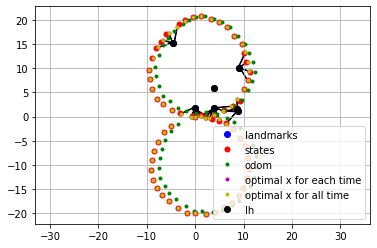

In [16]:
import matplotlib.pyplot as plt
lh = np.concatenate(result.optimized_values['landmarks']).reshape([len(lm),2])
xh = np.concatenate(result.optimized_values['poses']).reshape([len(x),2])
print('lh:', lh)
print('xh:', xh)
fig = plt.figure(1)
plt.plot(lm[:, 0], lm[:, 1], 'bo', label='landmarks')
plt.plot(x[:, 0], x[:, 1], 'r.', label='states', markersize=10)
#plot odom
x_odom = np.array([0, 0], dtype=float)
x_odom_hist = [x_odom]
for odom_i in odom:
    x_odom = np.array(x_odom) + np.array(odom_i[:2])
    x_odom_hist.append(x_odom)
x_odom_hist = np.array(x_odom_hist)
plt.plot(x_odom_hist[:, 0], x_odom_hist[:, 1], 'g.', linewidth=3, label='odom')
# plot best estimate history from each time step
plt.plot(xh[:,0], xh[:,1], 'm.', linewidth=3, label='optimal x for each time')
# plot best estimate from the final time step
plt.plot(xh[:,0], xh[:,1], 'y.', linewidth=3, label='optimal x for all time')
# plot best estimate landmarks
plt.plot(lh[:, 0], lh[:, 1], 'ko', label='lh')
#plt.plot(hist['lh'][-1])
# plot measurements
for rng, bearing, xi, li in z:
    xi = int(xi)
    x = xh[xi, :]
    plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
                  length_includes_head=True)
# # plot measurements
# for rng, bearing, xi in hist['z']:
#     xi = int(xi)
#     x = x_odom_hist[xi, :]
#     plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
#                   length_includes_head=True)
# plt.axis([0, 10, 0, 10])
plt.axis([5, 10, 0, 2])
plt.grid()
plt.legend()
plt.axis('equal');

In [ ]:
# data from sim
odom = sim['hist']['odom']
l = sim['landmarks']
z = sim['hist']['z']
hist = sim['hist']

# initialize x guess from odom
x0 = sim['hist']['x']
# print(x0[:,0].shape)
x1 = x0[:,0]
x2 = x0[:,1]
l1 = l[:,0]
l2 = l[:,1]
x0_new = np.hstack([x1, x2, l1, l2])
n_x = len(hist['x'])
x0_all = np.zeros([n_x+1,2])
x0_all[1: :] = x0

# compute data associations
assoc = [ slam2d.data_association(x0_all[int(xi), :], np.array([rng, bearing]), l) for rng, bearing, xi in z ]
print(assoc)

# build cost
f_J, J = slam2d.build_cost(odom, z, assoc, x0.shape[0], l.shape[0])

# compute cost , this is where we will send it to casadi nonlinear optim
f_J(x0, l)

# Symbols/expressions
nlp = {}                 # NLP declaration
nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
nlp['f'] = J           # objective
nlp['g'] = 0             # constraints

# Create solver instance
F = ca.nlpsol('F','ipopt',nlp);

# Solve the problem using a guess
# This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
optim = F(x0=x0_new)

# Re-associate landmark/measurements given new xstar positions
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
x_allstar = np.zeros([n_x+1,2])
x_allstar[1: :] = xstar

zstar = []
for i in range(n_x):
    x = x_allstar[i,:]
    
    # measure landmarks
    z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

    for z in z_list:
        zstar.append(np.hstack([z, i]))

zstar = np.array(zstar)


new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]
print(type(new_assoc))

# # Loop through optimization and reassociation until the new association matches the old association.
# while new_assoc != assoc:
#     # build cost
#     f_J, J = slam2d.build_cost(odom, z, new_assoc, xstar.shape[0], lstar.shape[0])

#     # compute cost , this is where we will send it to casadi nonlinear optim
#     f_J(xstar, l)

#     # Symbols/expressions
#     nlp = {}                 # NLP declaration
#     nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
#     nlp['f'] = J           # objective
#     nlp['g'] = 0             # constraints

#     # Create solver instance
#     F = ca.nlpsol('F','ipopt',nlp);

#     # Solve the problem using a guess
#     # This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
#     xstar1 = xstar[:,0]
#     xstar2 = xstar[:,1]
#     lstar1 = l[:,0]
#     lstar2 = l[:,1]
#     xstar_new = np.hstack([xstar1, xstar2, lstar1, lstar2])
#     optim = F(x0=xstar_new)

#     # Re-associate landmark/measurements given new xstar positions
#     hist = sim['hist']
#     n_x = len(hist['x'])
#     n_l = len(sim['landmarks'])
#     xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
#     lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
#     x_allstar = np.zeros([n_x+1,2])
#     x_allstar[1: :] = xstar

#     zstar = []
#     for i in range(n_x):
#         x = x_allstar[i,:]

#         # measure landmarks
#         z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

#         for z in z_list:
#             zstar.append(np.hstack([z, i]))

#     zstar = np.array(zstar)


#     new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]


In [7]:
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.zeros([n_x+1,2])
xstar[1: :] = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
print(optim['f'])
plt.figure(figsize=(10, 5))
slam2d.plot_me(sim)
for rng, bearing, xi in hist['z']:
    xi = int(xi)
    x = xstar[xi, :]
    # plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
    #               length_includes_head=True)
plt.plot(xstar[:, 0], xstar[:, 1], 'm.', linewidth=3, label='xstar')
plt.plot(lstar[:, 0], lstar[:, 1], 'ko', label='lstar')
plt.legend()

KeyError: 'landmarks'

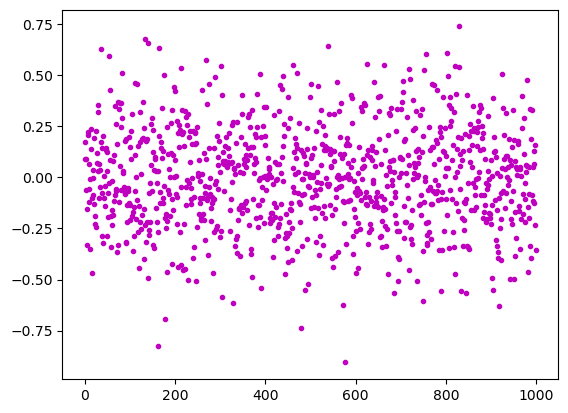

In [8]:
for lcv in range(1000):
    x = np.random.uniform(-1, 1)
    x_norm = (np.random.randn() + 0) / (4) * 1
    x2 = np.random.randn()
    # plt.plot(lcv,x,'r.')
    # plt.plot(lcv,x2,'k.')
    plt.plot(lcv,x_norm,'m.')

In [6]:
ca.__version__

'3.5.5'